<a href="https://colab.research.google.com/github/israr96418/Human_acvtivity_recognition/blob/main/human_activity_recognition_video_baseipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import Required library for my model
!pip install pafy
!pip install youtube-dl moviepy
!pip install imageio-ffmpeg
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy





Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 35.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/TahaAnwar/pafy.git to /tmp/pip-install-w74s4awo/pafy_70b52ae28ebd4d5ab73a761ed434cd1a
  Running command git clone -q https://github.com/TahaAnwar/pafy.git /tmp/pip-install-w74s4awo/pafy_70b52ae28ebd4d5ab73a761ed434cd1a


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [58]:

import os
import numpy as np
import tensorflow as tf
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline
# pafy---> is python library to download youtube content and retrieve metatdata
import pafy
import datetime as dt
from collections import deque

# moviepy is a python module used for video editing , which can used for basic operation(like cut, concatenation,title insertion)
# video compostitin(non linear editing), video processing, or to create advance effect

# from moviepy.editor import *

# it will split the our dataset into train and test
from sklearn.model_selection import train_test_split
from keras.layers import ConvLSTM2D,MaxPooling3D,Dropout, TimeDistributed, Flatten,Dense,LSTM,MaxPooling2D,Conv2D
from keras import Sequential
from keras.utils import to_categorical,plot_model
from keras.callbacks import EarlyStopping

In [4]:

# After that we will set numpy, python, tensorflow seed to get consistent result on every execution
# it means it reduce randomness
import random

seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

plt.figure(figsize=(20,20))

# get the names of all classes/catagories from dataset

all_classes_names = os.listdir("/content/UCF50")


# Generate the list of 20 random values , the value will be b/w 0-50
# where 50 is the total number of classes/catagories in the dataset

import random

random_range = random.sample(range(len(all_classes_names)), 20)

<Figure size 1440x1440 with 0 Axes>

In [1]:
# Discard the output of this cell.
%%capture

# Downlaod the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extract the Dataset
!unrar x UCF50.rar

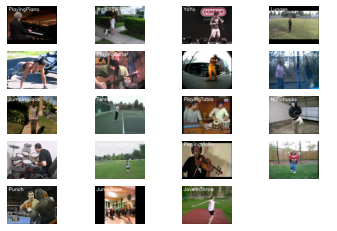

In [5]:
# iterate through all of the randomly genereated value
for counter, random_index in enumerate(random_range,1):
    
    # retrive class_name by using random index
    select_class_name = all_classes_names[random_index]
    
    # Retrive the list of all video files present in the randomly selected class directory
    video_files_name_list = os.listdir(f"/content/UCF50/{select_class_name}")
    
    # Randomly selected a video file from the list of the retrived from the randomly select class directory
    selected_video_file_name = random.choice(video_files_name_list)
    
    # initialized a videocapture object to read from the video file
    video_reader = cv2.VideoCapture(f"/content/UCF50/{select_class_name}/{selected_video_file_name}")
    
    
    # Read the first frame of  the video file
    _, bgr_frame = video_reader.read()
    
    # Realse the video capture object
    video_reader.release()
    
    # convert the frame from bgr to rbg formate
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    
    # write the class name on each video frame 
    cv2.putText(rgb_frame, select_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    
    # Display the frame
    plt.imshow(rgb_frame)
    plt.subplot(5,4,counter)
    plt.axis('off')
    

In [63]:
IMAGE_WIDTH, IMAGE_HEIGHT = 64,64

# it specify the number of frames of a video that will be feed to the model as a sequence
# if we increase sequence lenght accuracy will increase but we need more computation for it
SEQ_LENGTH = 25
DATASET_DIR = "/content/UCF50"
CLASS_LIST=['Basketball', 'MilitaryParade', 'WalkingWithDog','PlayingGuitar' ]
CHANNELS =3
input_shape = (SEQ_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH,CHANNELS)

In [8]:
def frame_extraction(video_path):
    """
    1: With the help of this function we extract frame from videos
    2: video_path: the path of the video in the disk , whose frame to be extracted
    3: frames_list : This list contain all the resized and normalized frames of the video
    """
    
    frames_list = []
    
    # Read the video file by using VideoCapture object
    video_reader = cv2.VideoCapture(video_path)
    
    # Get total number of frames from video 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate the interval after which frame will be added to the list
    skip_frame_window = max(int(video_frames_count/SEQ_LENGTH),1)
    
    # iterate throught video frames
    for frame_counter in range(SEQ_LENGTH):
        
        # set the current frame position of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frame_window)
        
        # read the frame from video
        success, frame = video_reader.read()
        
        #check video frame is successfully read or not
        # if not break
        if not success:
            break
        
        # Resize each frame to fixed width and height 
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT,IMAGE_WIDTH))
        
        # After reszing the frame , Normalized each pixel by dividing 255 to lie b/w [0-1]
        normalized_frame = resized_frame/255
        
        # Append the normalized frame to list
        frames_list.append(normalized_frame)
        
    video_reader.release()
    
    return frames_list
    

In [11]:
def create_dateset():
    """
    features[]--> it will contain the extracted frames of the video 
    labels[]-->   it will contain the indexes of the classes associated with video
    video_files_path[]--> it will contain the path of video in the index
    """
    features = []
    labels = []
    video_files_paths = []
#     print(CLASS_LIST)
    # iterate through all the classes mentioned in the class list
    for class_index, class_name in enumerate(CLASS_LIST):
        print(f"Extracted data of the class: {class_name}")
        
    # Get the list of the video files present in the specific class name directory
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
    
    # Iterate through all the files present in the file list
        print("total_files/video:" ,len(files_list))
        for file_name in files_list:
               # Get the complete video path
            video_file_path= os.path.join(DATASET_DIR,class_name,file_name)

            # Extract the frames of the video file
            frames = frame_extraction(video_file_path)

             # Check if the extracted frames are equal to the SEQ_LENGTH specified above.
             # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQ_LENGTH:
                # Append the data to their respective list:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

            # convert list to the numpy array
    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_file_path

features, labels, video_files_paths = create_dateset()

Extracted data of the class: Basketball
total_files/video: 137
Extracted data of the class: MilitaryParade
total_files/video: 127
Extracted data of the class: WalkingWithDog
total_files/video: 123
Extracted data of the class: PlayingGuitar
total_files/video: 160


In [12]:
# # Now we will convert the class_label(index) into one-hot-encoded vectors
one_hot_encoded_vectors = to_categorical(labels)


In [13]:
feature_train, feature_test, label_train, label_test = train_test_split(features, one_hot_encoded_vectors, test_size=0.2, shuffle=True, random_state=seed_constant)

In [ ]:
# train_model_evaluate = convlstm_model.evaluate(feature_test,label_test)

In [14]:
def create_convlstm_model():
    """This function will construct the required convlstm approach
        It will return the required constructed model"""
    # we will use sequental model for model construction
    model = Sequential()
    
    
    
#     Convlstm model construction

#     First ConvLSTM2D cell
    model.add(ConvLSTM2D(filters=4, kernel_size=(3,3), activation='relu', data_format='channels_last',
                         recurrent_dropout=0.2,return_sequences=True, 
                         input_shape=(SEQ_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)))
#     Noramly we will used MaxPooling2d when we working with simple image classification
     # but here we are working with video base classifition so we used MaxPoolinf3D which work very well with video
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    
    #     2nd ConvLSTM2D cell
    model.add(ConvLSTM2D(filters=8, kernel_size=(3,3), activation='relu', data_format='channels_last',
                         recurrent_dropout=0.2,return_sequences=True, 
                         input_shape=(SEQ_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    
    
    #     3rd ConvLSTM2D cell
    model.add(ConvLSTM2D(filters=14, kernel_size=(3,3), activation='relu', data_format='channels_last',
                         recurrent_dropout=0.2,return_sequences=True, 
                         input_shape=(SEQ_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    
    #     4th ConvLSTM2D cell
    model.add(ConvLSTM2D(filters=16, kernel_size=(3,3), activation='relu', data_format='channels_last',
                         recurrent_dropout=0.2,return_sequences=True, 
                         input_shape=(SEQ_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
    # model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(len(CLASS_LIST), activation='softmax'))
    
    # model.summary()
    return model

convlstm_model = create_convlstm_model()
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

convlstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
convlstm_model_training_history2 = convlstm_model.fit(x = feature_train, y = label_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
88/88 [==============================] - 85s 743ms/step - loss: 1.3928 - accuracy: 0.2951 - val_loss: 1.3951 - val_accuracy: 0.2386
Epoch 2/50
88/88 [==============================] - 61s 689ms/step - loss: 1.3644 - accuracy: 0.3238 - val_loss: 1.3129 - val_accuracy: 0.2386
Epoch 3/50
88/88 [==============================] - 60s 680ms/step - loss: 1.2378 - accuracy: 0.3524 - val_loss: 1.1553 - val_accuracy: 0.4545
Epoch 4/50
88/88 [==============================] - 64s 731ms/step - loss: 0.9890 - accuracy: 0.5817 - val_loss: 0.9189 - val_accuracy: 0.6364
Epoch 5/50
88/88 [==============================] - 60s 683ms/step - loss: 0.8466 - accuracy: 0.6476 - val_loss: 1.0698 - val_accuracy: 0.5909
Epoch 6/50
88/88 [==============================] - 59s 675ms/step - loss: 0.7004 - accuracy: 0.7450 - val_loss: 0.7962 - val_accuracy: 0.7614
Epoch 7/50
88/88 [==============================] - 59s 675ms/step - loss: 0.6430 - accuracy: 0.7278 - val_loss: 0.7341 - val_accuracy: 0.7159

In [15]:
train_model_evaluate2 = convlstm_model.evaluate(feature_test,label_test)

4/4 [==============================] - 2s 128ms/step - loss: 0.5495 - accuracy: 0.8727


In [16]:
convlstm_loss, convlstm_accuracy = train_model_evaluate2
date_time_foramte = '%Y_%m_%d__%H_%M_%S'
current_date_time = dt.datetime.now()
current_datatime_tostring=dt.datetime.strftime(current_date_time,date_time_foramte)
save_my_train_model =f"datetime{current_date_time}__loss_model{convlstm_loss}__accuracy_model{convlstm_accuracy}.h5"
convlstm_model.save(save_my_train_model)

**Plot our train model to visualized train_loss trest_loss, train_accuracy and test_accurac**

In [24]:
def plot_metric(convlstm_model_training_history2, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = convlstm_model_training_history2.history[metric_name_1]
    metric_value_2 = convlstm_model_training_history2.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

ValueError: ignored

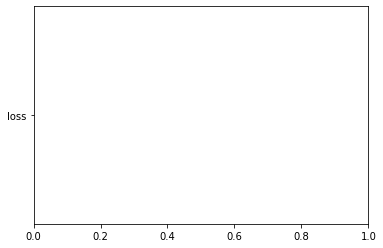

In [25]:
# visualized the training and validation loss metric  
plot_metrice(convlstm_model_training_history2, 'loss', 'val_loss','Total_loss vs Total Validation loss')

ValueError: ignored

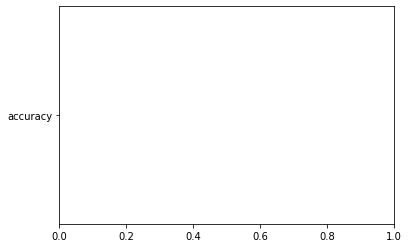

In [28]:
plot_metrice(convlstm_model_training_history2, 'accuracy', 'val_accuracy','train_accuracy vs Total val_accuary loo')

# Implemnet LRCN(Long-term Recurrent convolutional Neural network

In this approch combination of both cnn-layers and lstm cell in a single model..Another similar approach is **CNN**(any cnn architecture)-**RNN**(lstm or gru) but in this approach we train both cnn-rnn model separtly.

The cnn model is used to extract saptial feature from the frames in videos and for this purpose we used pre-trained model that can fine tuned for the problem and LSTM model can then used the feature extracted by cnn, to predict action being performed in the video

But here we will implement LRCN. which combine both cnn and lstm layers in a single model.
Convolutional layer are used to extract spatial features from the frames of videos, and extracted spatial features are fed to the lsmt layers at each time stamp step for temporal sequencel model.
This way the network learn **spatiotemporal** features 

**Contruct LRCN**

In [85]:

# def create_lrcn_model():
  # model = Sequential()

# # LRCN Architecture
# # TimeDistributed layer are used to avoid Dependencies


# # CNN_Layer1
#   model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=input_shape)))
#   model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
#   model.add(TimeDistributed(Dropout(0.25)))


# # CNN_Layer2
#   model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
#   model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
#   model.add(TimeDistributed(Dropout(0.25)))

# # CNN_Layer3
#   model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
#   model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
#   model.add(TimeDistributed(Dropout(0.25)))

# # CNN_Layer4
#   model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
#   model.add(TimeDistributed(MaxPooling2D((2, 2)))) 

#   model.add(TimeDistributed(Flatten()))
#   model.add(LSTM(32))

#   model.add(Dense(len(CLASS_LIST), activation = 'softmax'))

#   model.build(input_shape = input_shape)
# # Display the model summay
#   model.summary()

#   return model





def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation = 'relu'),input_shape = (20, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)))) 
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASS_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    model.build(input_shape=(20, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    # Return the constructed LRCN model.
    return model

In [86]:
LRCN_MODEL =  create_lrcn_model()

ValueError: ignored